In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

In [3]:
ab_test_imp = pd.read_csv('R/section5-ab_test_imp.csv')
ab_test_imp.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id
0,2013-10-01,game-01,sales_test,B,36703,25622
1,2013-10-01,game-01,sales_test,A,44339,25623
2,2013-10-01,game-01,sales_test,B,32087,25624
3,2013-10-01,game-01,sales_test,B,10160,25625
4,2013-10-01,game-01,sales_test,B,46113,25626


In [4]:
ab_test_goal = pd.read_csv('R/section5-ab_test_goal.csv')
ab_test_goal.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id
0,2013-10-01,game-01,sales_test,B,15021,25638
1,2013-10-01,game-01,sales_test,B,351,25704
2,2013-10-01,game-01,sales_test,B,8276,25739
3,2013-10-01,game-01,sales_test,B,1230,25742
4,2013-10-01,game-01,sales_test,B,17471,25743


In [5]:
ab_test_imp_goal = pd.merge(ab_test_imp, ab_test_goal, on=['transaction_id'], how='outer', suffixes=['', '.g'])
ab_test_imp_goal.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id,log_date.g,app_name.g,test_name.g,test_case.g,user_id.g
0,2013-10-01,game-01,sales_test,B,36703,25622,NaN,NaN,NaN,NaN,NaN
1,2013-10-01,game-01,sales_test,A,44339,25623,NaN,NaN,NaN,NaN,NaN
2,2013-10-01,game-01,sales_test,B,32087,25624,NaN,NaN,NaN,NaN,NaN
3,2013-10-01,game-01,sales_test,B,10160,25625,NaN,NaN,NaN,NaN,NaN
4,2013-10-01,game-01,sales_test,B,46113,25626,NaN,NaN,NaN,NaN,NaN


In [6]:
ab_test_imp_goal['is_goal'] = 1 - ab_test_imp_goal['user_id.g'].apply(np.isnan).astype(int)
ab_test_imp_goal.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id,log_date.g,app_name.g,test_name.g,test_case.g,user_id.g,is_goal
0,2013-10-01,game-01,sales_test,B,36703,25622,NaN,NaN,NaN,NaN,NaN,0
1,2013-10-01,game-01,sales_test,A,44339,25623,NaN,NaN,NaN,NaN,NaN,0
2,2013-10-01,game-01,sales_test,B,32087,25624,NaN,NaN,NaN,NaN,NaN,0
3,2013-10-01,game-01,sales_test,B,10160,25625,NaN,NaN,NaN,NaN,NaN,0
4,2013-10-01,game-01,sales_test,B,46113,25626,NaN,NaN,NaN,NaN,NaN,0


In [7]:
sum_goal = ab_test_imp_goal.groupby('test_case')['is_goal'].sum()
sz_user = ab_test_imp.groupby('test_case')['user_id'].size()
cvr = sum_goal / sz_user
pd.DataFrame(cvr, columns = ["cvr"])

,cvr
test_case,
A,0.080256
B,0.115460


In [9]:
cr = ab_test_imp_goal.pivot_table(index='test_case', columns='is_goal', values='user_id', aggfunc='count')
cr

is_goal,0,1
test_case,,
A,40592,3542
B,38734,5056


In [10]:
chi2, p, dof, expected = chi2_contingency(cr.as_matrix())
print(chi2)
print(dof)
print(p)

308.37505289322877
1
4.934139633785632e-69


In [12]:
ab_test_imp_goal_summary = ab_test_imp_goal.groupby(["log_date", "test_case"])["is_goal"].agg({"imp": "count", "cv": "sum"}).reset_index()
ab_test_imp_goal_summary["cvr"] = ab_test_imp_goal_summary["cv"] / ab_test_imp_goal_summary["imp"]
ab_test_imp_goal_summary.head()

# total_per_day = pd.pivot_table(ab_test_imp, index=['log_date'], columns=['test_case'], values='transaction_id', aggfunc='count')
# total_per_day.head()

/Users/TomohikoIto/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,log_date,test_case,imp,cv,cvr
0,2013-10-01,A,1358,98,0.072165
1,2013-10-01,B,1391,176,0.126528
2,2013-10-02,A,1370,88,0.064234
3,2013-10-02,B,1333,212,0.159040
4,2013-10-03,A,1213,170,0.140148


In [13]:
tmp = ab_test_imp_goal_summary.drop("cvr", axis = 1).groupby("test_case").sum()
tmp["cvr_avg"] = tmp["cv"] / tmp["imp"]
tmp = tmp[["cvr_avg"]].reset_index()
pd.merge(ab_test_imp_goal_summary, tmp).head()

,log_date,test_case,imp,cv,cvr,cvr_avg
0,2013-10-01,A,1358,98,0.072165,0.080256
1,2013-10-02,A,1370,88,0.064234,0.080256
2,2013-10-03,A,1213,170,0.140148,0.080256
3,2013-10-04,A,1521,89,0.058514,0.080256
4,2013-10-05,A,1587,56,0.035287,0.080256


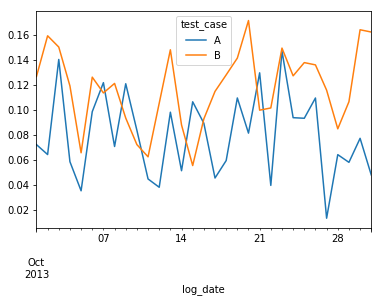

In [16]:
ab_test_imp_goal_summary["log_date"] = pd.to_datetime(ab_test_imp_goal_summary["log_date"])
ab_test_imp_goal_summary[["log_date", "test_case", "cvr"]].groupby(["log_date", "test_case"])["cvr"].max().unstack().plot()